<a href="https://colab.research.google.com/github/ab2gbl/ECG-detection/blob/main/QRS_detection/TCN/TCN_QTDB%2BLUDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!cp -r '/content/drive/MyDrive/Final project/dataset/physionet.org' '/content/physionet.org'

In [1]:
!pip install wfdb

In [2]:
import wfdb
from scipy.signal import butter, filtfilt
import numpy as np
from scipy.signal import resample
from re import S
import os

In [3]:
def bandpass_filter(signal, lowcut=0.5, highcut=40, fs=250, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)
def smooth_signal(data, window_size=5):
    # Smooth the signal using a moving average filter
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed
def normalize_signal(data):
    """
    Normalize the signal using z-score normalization.
    """
    return (data - np.mean(data)) / np.std(data)


In [4]:
def extract_qrs_regions(samples, symbols, fs, extra_ms=0):

    qrs_regions = []
    start = None
    nested_count = 0  # Track nested parentheses
    current_symbol = None  # Track if 'N' appears
    extra_samples = int((extra_ms / 1000) * fs)  # Convert ms to samples
    for i in range(len(symbols)):
        if symbols[i] == '(':
            if nested_count == 0:  # First `(` marks the start
                start = samples[i]
                current_symbol = None  # Reset tracking
            nested_count += 1  # Increase nested count

        elif symbols[i] == 'N':  # Identify QRS region
            current_symbol = 'N'

        elif symbols[i] == ')':
            nested_count -= 1  # Reduce nested count
            if nested_count == 0 and start is not None:
                if current_symbol == 'N':  # Only save if 'N' was in the segment
                    end = samples[i] + extra_samples
                    qrs_regions.append((start, end))
                start = None
                current_symbol = None  # Reset tracking

    return qrs_regions



In [5]:


def resample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal


def adjust_annotations(samples, original_fs, target_fs):
    return (samples * target_fs / original_fs).astype(int)



In [6]:

def create_binary_mask(signal, qrs_regions):
    mask = np.zeros(len(signal))
    for start, end in qrs_regions:
        mask[start:end] = 1  # Mark QRS regions as 1
    return mask


In [7]:
def segment_signal_and_mask(signal, mask, window_size, fs):
    segments = []
    masks = []
    for i in range(0, len(signal) - window_size, window_size // 2):  # 50% overlap
        segment = signal[i:i + window_size]
        mask_segment = mask[i:i + window_size]
        segments.append(segment)
        masks.append(mask_segment)
    return np.array(segments), np.array(masks)


In [8]:

def process_record(record_path, Type, extra_ms=0):
    # Load signal
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal[:, 0]  # Use lead I
    if Type=='QTDB':
      annotations = wfdb.rdann(record_path, 'pu')
    else:
      annotations = wfdb.rdann(record_path, 'i')
    samples = annotations.sample  # Annotation sample locations
    symbols = annotations.symbol  # Annotation symbols
    fs = record.fs  # Sampling frequency (500 Hz)

    # Preprocess
    signal = normalize_signal(smooth_signal(bandpass_filter(signal)))

    # Extract QRS
    if Type=='QTDB':
      qrs_regions = extract_qrs_regions(samples, symbols,fs,extra_ms=extra_ms)
    else :
      qrs_regions = extract_qrs_regions(samples, symbols,fs)

    # Resampling to 250 Hz
    if fs!=250:
      # Example: Resample QTDB signal from 500 Hz to 250 Hz
      signal = resample_signal(signal, original_fs=fs, target_fs=250)


      # Example: Adjust QTDB annotations
      qrs_regions = [(adjust_annotations(start, original_fs=fs, target_fs=250),
                                  adjust_annotations(end, original_fs=fs, target_fs=250))
                                  for start, end in qrs_regions]
      fs=250

    # Create binary masks
    mask = create_binary_mask(signal, qrs_regions)


    # Segment the signals and masks
    window_size = int(1 * fs)  # 1-second window (based on LUDB's fs)
    segments, masks = segment_signal_and_mask(signal, mask, window_size, fs)

    return segments, masks


In [9]:
def get_all_records(directory, extension=".dat"):
    files = [f.replace(extension, "") for f in os.listdir(directory) if f.endswith(extension)]
    return list(set(files))  # Ensure no duplicates

# Set paths for QTDB and LUDB
qtdb_path = "/content/physionet.org/files/qtdb/1.0.0/"
ludb_path = "/content/physionet.org/files/ludb/1.0.1/data/"

# Get all record names dynamically
qt_records = get_all_records(qtdb_path)
lu_records = get_all_records(ludb_path)

print(f"Found {len(qt_records)} QTDB records and {len(lu_records)} LUDB records.")

Found 105 QTDB records and 200 LUDB records.


In [10]:
qt_segments_list, qt_masks_list = [], []

for record_path in qt_records:
    try:
        print(f"Processing {record_path}")
        segments, masks = process_record(qtdb_path+record_path, Type='QTDB', extra_ms=20)  # Resample to 250 Hz
        qt_segments_list.append(segments)
        qt_masks_list.append(masks)
    except:
        print(f"Skipping {record_path} due to error.")

Processing sel45
Processing sel223
Processing sele0104
Processing sel14046
Processing sel36
Processing sel46
Processing sel14157
Processing sel891
Processing sele0409
Processing sele0509
Processing sel38
Processing sel39
Processing sel103
Processing sel16272
Processing sel840
Processing sele0121
Processing sele0124
Processing sele0411
Processing sel233
Processing sel117
Processing sel48
Processing sele0406
Processing sel33
Processing sele0129
Processing sele0106
Processing sel230
Processing sel16795
Processing sele0166
Processing sel883
Processing sel871
Processing sel232
Processing sel16539
Processing sele0704
Processing sel821
Processing sele0126
Processing sel213
Processing sel43
Processing sel44
Processing sel306
Processing sele0110
Processing sele0114
Processing sel41
Processing sele0303
Processing sel310
Processing sele0607
Processing sel820
Processing sel811
Processing sel31
Processing sele0136
Processing sel47
Processing sel37
Processing sel116
Processing sel51
Processing sel16

In [11]:

lu_segments_list, lu_masks_list = [], []
for record_path in lu_records:
    try:
        print(f"Processing {record_path}")
        segments, masks = process_record(ludb_path+record_path, Type='LUDB', extra_ms=0)
        lu_segments_list.append(segments)
        lu_masks_list.append(masks)
    except:
        print(f"Skipping {record_path} due to error.")

Processing 121
Processing 73
Processing 125
Processing 29
Processing 79
Processing 140
Processing 47
Processing 3
Processing 122
Processing 97
Processing 167
Processing 118
Processing 8
Processing 143
Processing 23
Processing 40
Processing 142
Processing 130
Processing 185
Processing 179
Processing 133
Processing 151
Processing 5
Processing 25
Processing 54
Processing 103
Processing 173
Processing 100
Processing 95
Processing 87
Processing 81
Processing 126
Processing 132
Processing 116
Processing 124
Processing 157
Processing 184
Processing 74
Processing 183
Processing 158
Processing 53
Processing 109
Processing 51
Processing 50
Processing 17
Processing 170
Processing 39
Processing 4
Processing 1
Processing 58
Processing 104
Processing 91
Processing 102
Processing 144
Processing 18
Processing 68
Processing 30
Processing 90
Processing 9
Processing 155
Processing 64
Processing 150
Processing 152
Processing 35
Processing 41
Processing 24
Processing 31
Processing 66
Processing 139
Process

In [12]:
qt_segments = np.concatenate(qt_segments_list, axis=0)
qt_masks = np.concatenate(qt_masks_list, axis=0)
lu_segments = np.concatenate(lu_segments_list, axis=0)
lu_masks = np.concatenate(lu_masks_list, axis=0)

In [13]:
# Combine into final dataset
X = np.concatenate([qt_segments, lu_segments])
y = np.concatenate([qt_masks, lu_masks])

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Add, Dense

def TCN(input_shape, num_filters, kernel_size, num_blocks, dropout_rate):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_blocks):
        # Residual block
        res = x
        x = Conv1D(num_filters, kernel_size, padding='causal')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv1D(num_filters, kernel_size, padding='causal')(x)
        x = BatchNormalization()(x)
        x = Add()([x, res])
        x = ReLU()(x)
    x = Conv1D(1, kernel_size=1, activation='sigmoid')(x)  # Output sequence of probabilities
    model = Model(inputs, x)
    return model
window_size=int(1*250)
# Define the TCN model
input_shape = (window_size, 1)
model = TCN(input_shape, num_filters=64, kernel_size=3, num_blocks=4, dropout_rate=0.2)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 250, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 250, 64)        │            256 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 250, 64)        │            256 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 250, 64)        │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 250, 64)        │         12,352 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 250, 64)        │            256 │ conv1d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 250, 64)        │              0 │ batch_normalization_1… │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 250, 64)        │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 250, 64)        │         12,352 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 250, 64)        │            256 │ conv1d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 250, 64)        │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 250, 64)        │         12,352 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 250, 64)        │            256 │ conv1d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 250, 64)        │              0 │ batch_normalization_3… │
│                           │                        │                │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 250, 64)        │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 250, 64)        │         12,352 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 88,833 (347.00 KB)

 Trainable params: 87,809 (343.00 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [16]:
# Reshape data for TCN input
X_train = X_train.reshape(-1, window_size, 1)
X_val = X_val.reshape(-1, window_size, 1)
X_test = X_test.reshape(-1, window_size, 1)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

Epoch 1/50
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - accuracy: 0.9316 - loss: 0.1851 - val_accuracy: 0.9446 - val_loss: 0.1548
Epoch 2/50
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.9461 - loss: 0.1492 - val_accuracy: 0.9478 - val_loss: 0.1424
Epoch 3/50
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accuracy: 0.9517 - loss: 0.1365 - val_accuracy: 0.9538 - val_loss: 0.1339
Epoch 4/50
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.9548 - loss: 0.1289 - val_accuracy: 0.9547 - val_loss: 0.1312
Epoch 5/50
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9563 - loss: 0.1253 - val_accuracy: 0.9571 - val_loss: 0.1263
Epoch 6/50
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - accuracy: 0.9575 - loss: 0.1231 - val_accuracy: 0.9593 - val_loss: 0.1192
Epoch 7/50
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.9584 - loss: 0.1205 - val_accuracy: 0.9596 - val_loss: 0.1172
Epoch 8/50
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.9592 - loss: 0

1203/1203 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9651 - loss: 0.1018
Test Accuracy: 0.9646210074424744
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


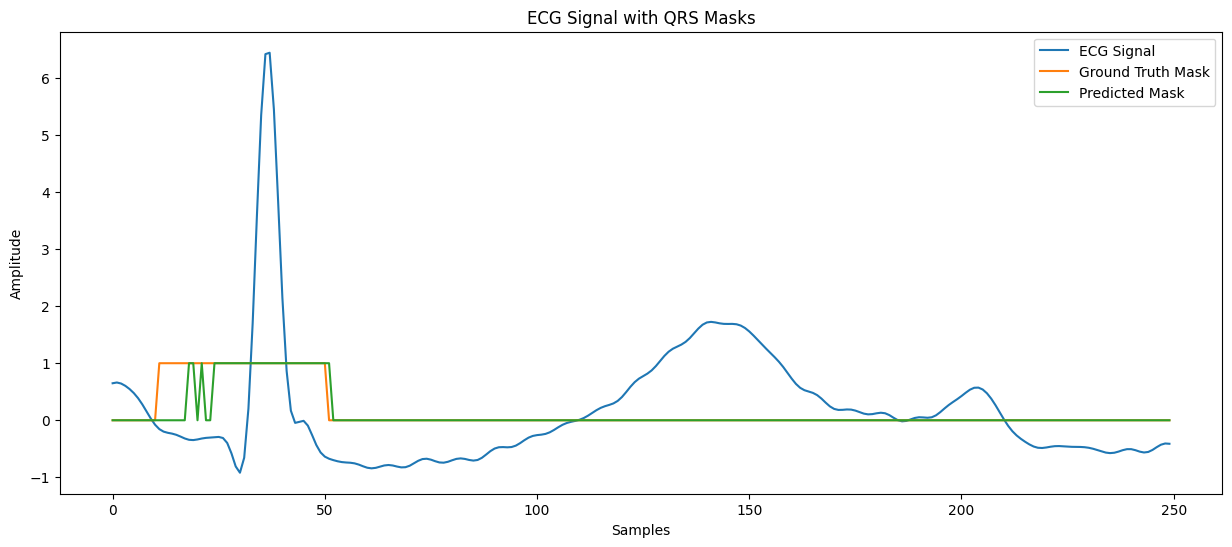

In [17]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

# Predict on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary masks

# Visualize predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(X_test[0].flatten(), label='ECG Signal')
plt.plot(y_test[0].flatten(), label='Ground Truth Mask')
plt.plot(y_pred[0].flatten(), label='Predicted Mask')
plt.title('ECG Signal with QRS Masks')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [18]:
from keras.saving import save_model

# Save the trained model
save_model(model,"/content/drive/MyDrive/Final project/QRS detection/TCN/Norm_model.keras")
model.save("/content/drive/MyDrive/Final project/QRS detection/TCN/Norm_model.keras")

In [19]:
import wfdb

# Load the new ECG signal
new_record = wfdb.rdrecord('/content/physionet.org/files/mitdb/1.0.0/100')

new_signal = new_record.p_signal[:, 0]  # Use lead I
new_fs = new_record.fs  # Sampling frequency

# Extract the first 10 seconds
first_10_seconds = new_signal[:int(10 * new_fs)]
print(first_10_seconds.shape)

(3600,)


In [20]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

first_10_seconds = normalize_signal(smooth_signal(bandpass_filter(first_10_seconds)))

first_10_seconds = resample_signal(first_10_seconds, original_fs=new_fs, target_fs=250)
# Segment the signal into fixed-length windows
def segment_signal(signal, window_size, fs):
    segments = []
    for i in range(0, len(signal) - window_size, window_size // 2):  # 50% overlap
        segment = signal[i:i + window_size]
        segments.append(segment)
    return np.array(segments)

window_size = int(1 * new_fs)  # 1-second window
new_segments = segment_signal(first_10_seconds, window_size, new_fs)

# Reshape for TCN input
new_segments = new_segments.reshape(-1, window_size, 1)
print(new_segments.shape)

(12, 360, 1)


In [21]:
# Predict QRS regions
y_pred = model.predict(new_segments)
print(y_pred)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary masks
print(y_pred[y_pred > 0])  # P
# Combine predictions into a single mask
full_mask = np.zeros(len(first_10_seconds))
for i, segment in enumerate(new_segments):
    start = i * (window_size // 2)
    end = start + window_size
    full_mask[start:end] = np.maximum(full_mask[start:end], y_pred[i].flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[[4.16257754e-02]
  [1.07586481e-01]
  [2.75725365e-01]
  ...
  [8.95612175e-04]
  [2.43943781e-04]
  [1.08703633e-03]]

 [[3.01812477e-02]
  [8.12393241e-03]
  [8.20339750e-03]
  ...
  [7.04154233e-03]
  [9.40895267e-03]
  [1.94069720e-03]]

 [[3.65678705e-02]
  [1.65545288e-02]
  [9.52115376e-03]
  ...
  [7.35561305e-04]
  [2.95173435e-04]
  [2.62170564e-04]]

 ...

 [[5.16119041e-02]
  [4.19249870e-02]
  [2.00898889e-02]
  ...
  [1.25576058e-04]
  [2.69855052e-04]
  [5.85333211e-04]]

 [[3.78299393e-02]
  [8.62963498e-03]
  [4.71913489e-03]
  ...
  [2.24888464e-03]
  [7.09620072e-04]
  [2.73793004e-03]]

 [[4.19279039e-02]
  [1.90399196e-02]
  [1.14307515e-02]
  ...
  [1.80896781e-02]
  [6.29223324e-03]
  [1.56402420e-02]]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 

In [22]:
def extract_qrs_from_mask(mask):
    qrs_regions = []
    start = None
    for i in range(len(mask)):
        if mask[i] == 1 and start is None:  # Start of QRS region
            start = i
        elif mask[i] == 0 and start is not None:  # End of QRS region
            end = i
            qrs_regions.append((start, end))
            start = None
    return qrs_regions

qrs_regions = extract_qrs_from_mask(full_mask)
print(qrs_regions)

[(46, 51), (54, 62), (247, 263), (453, 456), (457, 460), (461, 468), (645, 665), (845, 846), (847, 864), (1043, 1047), (1049, 1051), (1053, 1061), (1249, 1252), (1253, 1256), (1257, 1267), (1411, 1412), (1413, 1419), (1422, 1427), (1661, 1662), (1663, 1664), (1665, 1669), (1670, 1674), (1869, 1870), (1873, 1876), (1877, 1878), (1881, 1888), (2073, 2077), (2078, 2089), (2273, 2287)]


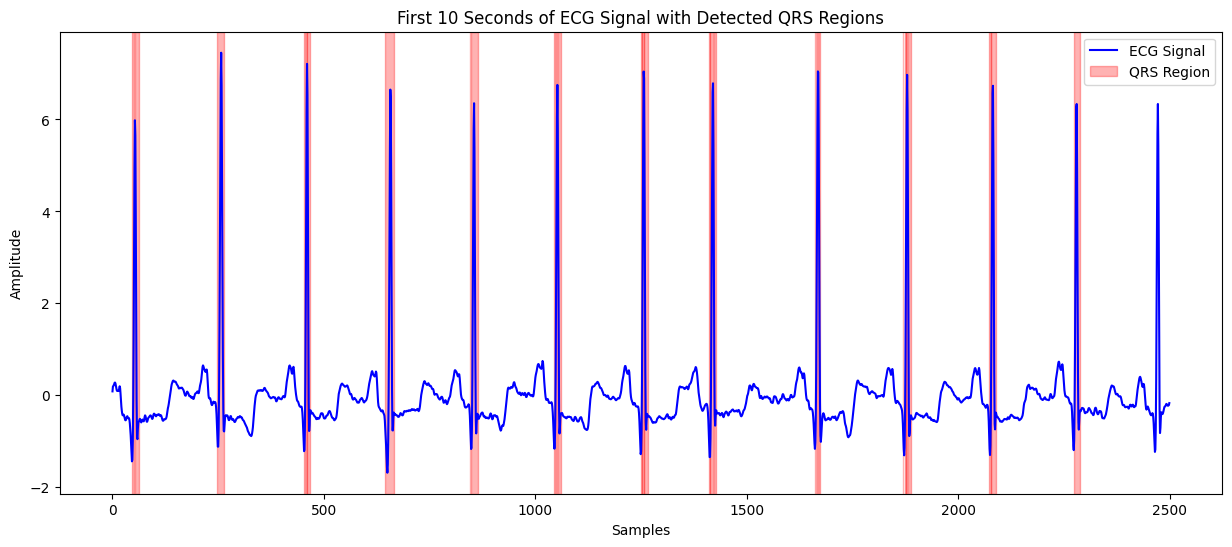

In [23]:
import matplotlib.pyplot as plt

# Plot the first 10 seconds of the ECG signal
plt.figure(figsize=(15, 6))
plt.plot(first_10_seconds, label='ECG Signal', color='b')

# Highlight QRS regions
for start, end in qrs_regions:
    plt.axvspan(start, end, color='r', alpha=0.3, label='QRS Region' if start == qrs_regions[0][0] else "")

plt.title('First 10 Seconds of ECG Signal with Detected QRS Regions')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
#plt.plot(y_pred[0].flatten(), label='Predicted Mask')
plt.legend()
plt.show()